In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv('train_data.txt', sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head(3)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...


In [3]:
test_data=pd.read_csv('test_data.txt',sep=':::',names=['Id','Title','Description'],engine='python')
test_data.head(3)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...


In [4]:
test_soln_data = pd.read_csv('test_data_solution.txt', sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_soln_data.drop(test_soln_data.columns[[0, 2]], axis=1, inplace=True)
test_soln_data.rename(columns = {'Title':'Actual Genre'}, inplace = True) 
test_soln_data.head(3)

,Actual Genre


In [5]:
train_data.Genre.value_counts()


Genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

C:\Users\guvva\AppData\Local\Temp\ipykernel_17220\4092516961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data,y='Genre',order=train_data['Genre'].value_counts().index,palette='viridis')


Text(0, 0.5, 'Distribution of Genres')

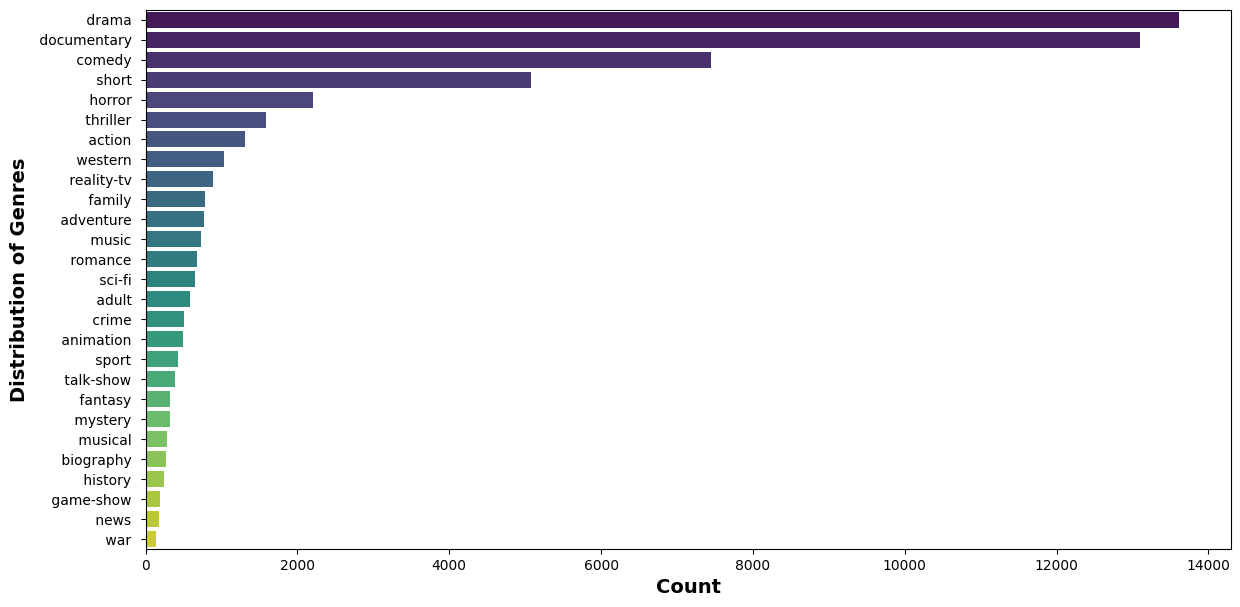

In [6]:
plt.figure(figsize=(14,7))
sns.countplot(data=train_data,y='Genre',order=train_data['Genre'].value_counts().index,palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Distribution of Genres', fontsize=14, fontweight='bold')

C:\Users\guvva\AppData\Local\Temp\ipykernel_17220\382012256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='mako')


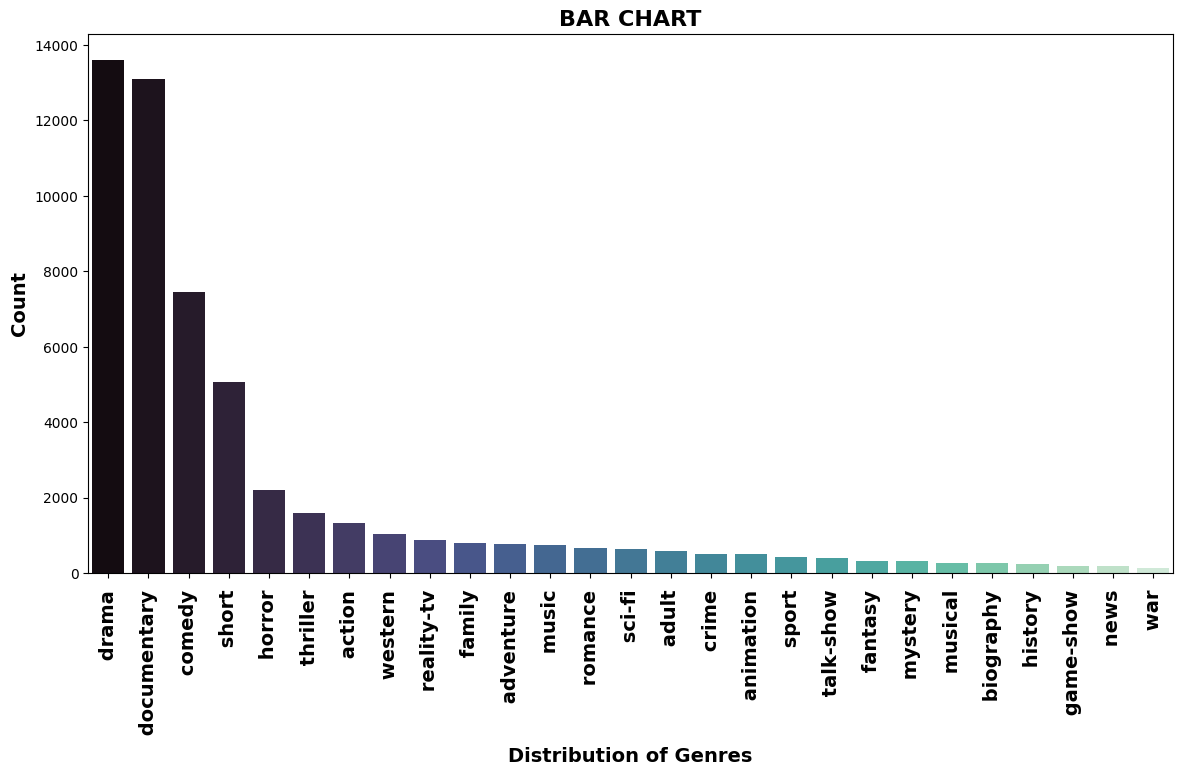

In [7]:
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='mako')
plt.xlabel('Distribution of Genres', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('BAR CHART', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [9]:
train_data.isnull().sum()


Title          0
Genre          0
Description    0
dtype: int64

In [10]:
from nltk.corpus import stopwords
import string

def clean_text(text):
    try:
        # Remove punctuation
        text = ''.join([char for char in text if char not in string.punctuation])
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)


In [11]:
print("shape before drop nulls",train_data.shape)
train_data = train_data.drop_duplicates()
print("shape after drop nulls",train_data.shape)

shape before drop nulls (54214, 4)
shape after drop nulls (54214, 4)


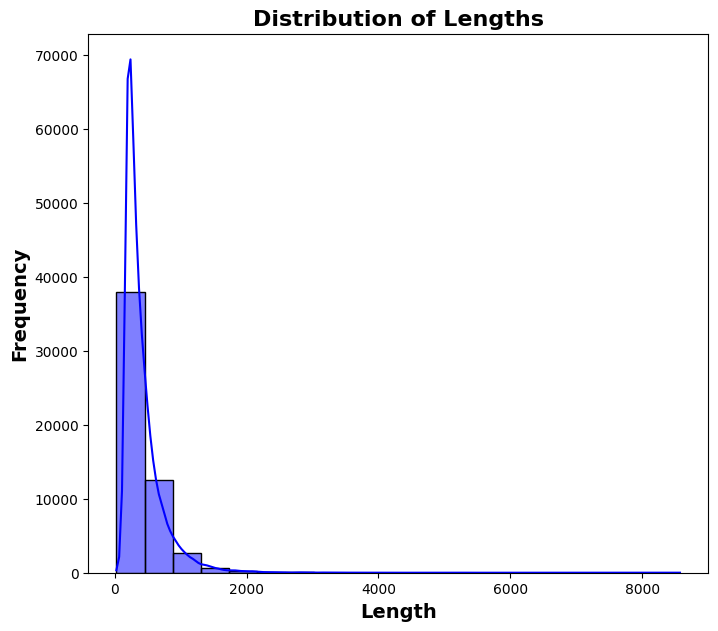

In [12]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

Text(0, 0.5, 'Frequency')

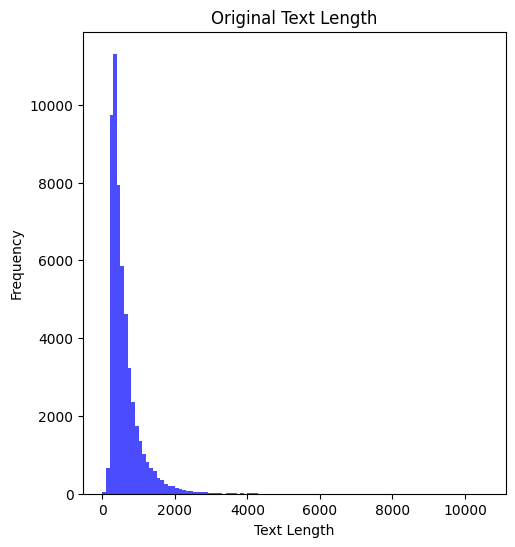

In [13]:
plt.figure(figsize=(12, 6))

# Subplot 1: Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')


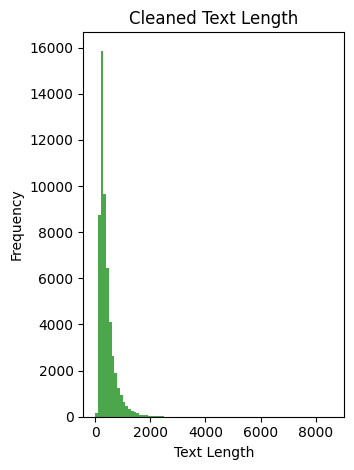

In [14]:
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [15]:
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [16]:
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_data['Genre_encoded']=label_encoder.fit_transform(train_data['Genre'])
train_data['Genre_encoded']
class_names=list(label_encoder.classes_)
class_names

[' action ',
 ' adult ',
 ' adventure ',
 ' animation ',
 ' biography ',
 ' comedy ',
 ' crime ',
 ' documentary ',
 ' drama ',
 ' family ',
 ' fantasy ',
 ' game-show ',
 ' history ',
 ' horror ',
 ' music ',
 ' musical ',
 ' mystery ',
 ' news ',
 ' reality-tv ',
 ' romance ',
 ' sci-fi ',
 ' short ',
 ' sport ',
 ' talk-show ',
 ' thriller ',
 ' war ',
 ' western ']

C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

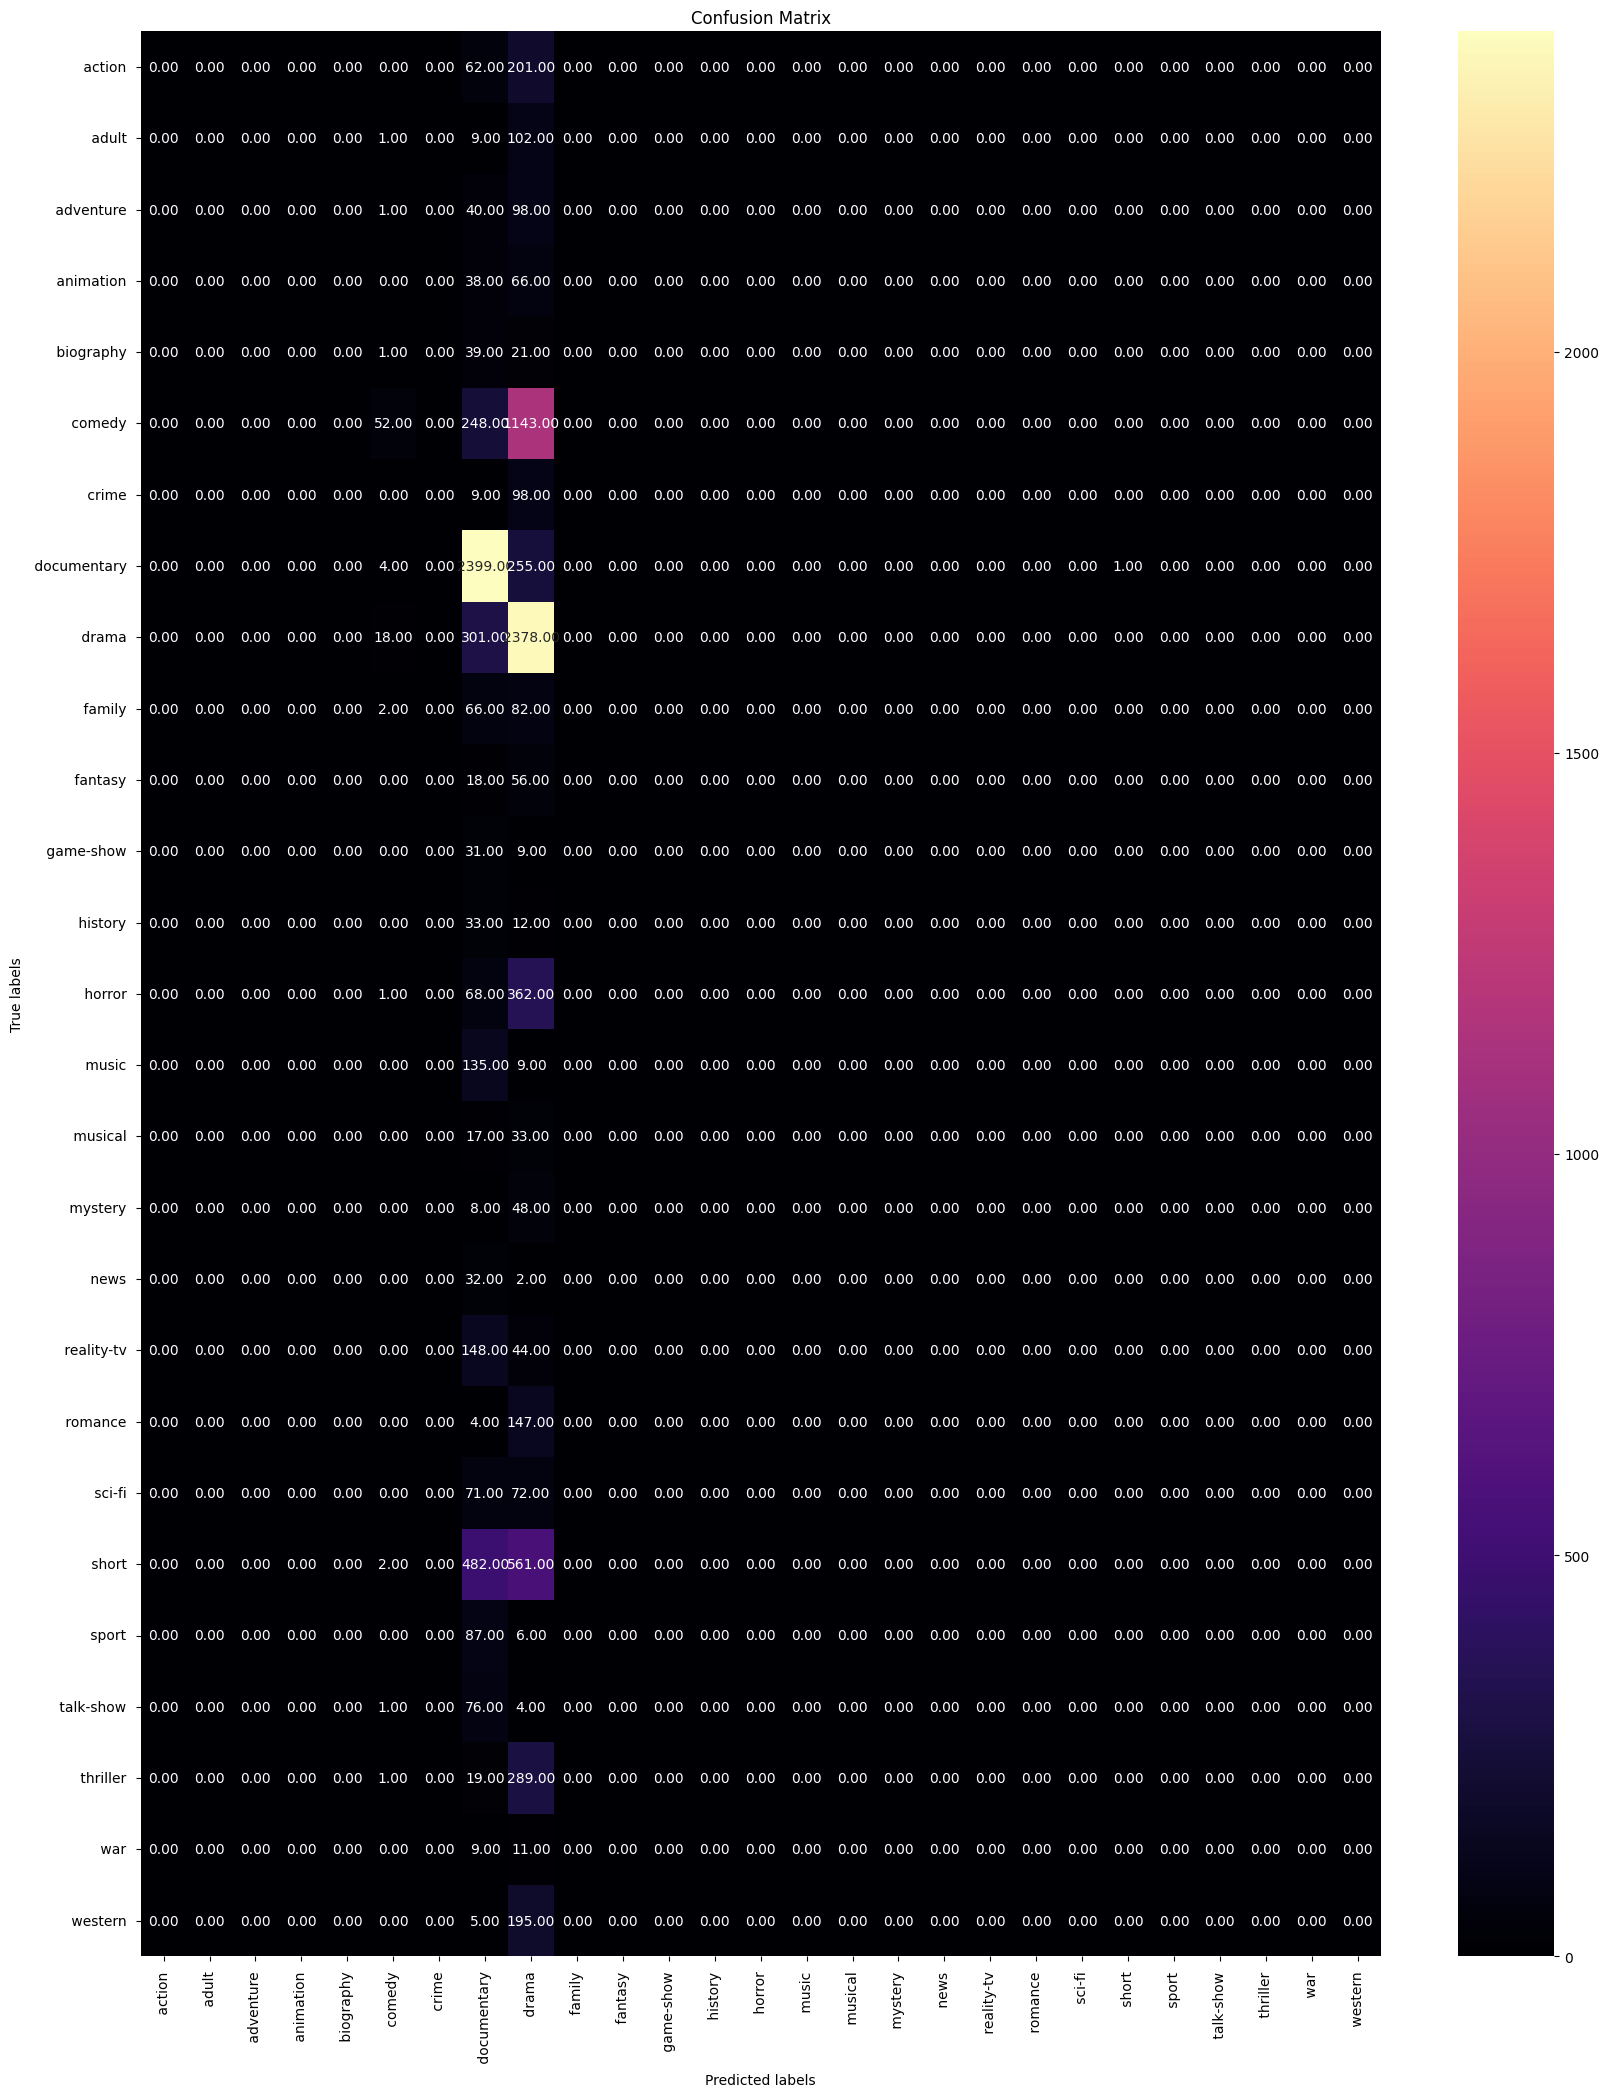

Classification Report:
               precision    recall  f1-score       support
 action         0.000000  0.000000  0.000000    263.000000
 adult          0.000000  0.000000  0.000000    112.000000
 adventure      0.000000  0.000000  0.000000    139.000000
 animation      0.000000  0.000000  0.000000    104.000000
 biography      0.000000  0.000000  0.000000     61.000000
 comedy         0.619048  0.036036  0.068107   1443.000000
 crime          0.000000  0.000000  0.000000    107.000000
 documentary    0.538617  0.902219  0.674540   2659.000000
 drama          0.377221  0.881720  0.528386   2697.000000
 family         0.000000  0.000000  0.000000    150.000000
 fantasy        0.000000  0.000000  0.000000     74.000000
 game-show      0.000000  0.000000  0.000000     40.000000
 history        0.000000  0.000000  0.000000     45.000000
 horror         0.000000  0.000000  0.000000    431.000000
 music          0.000000  0.000000  0.000000    144.000000
 musical        0.000000  0.00000

In [27]:
# Initialize and train a Multinomial Naive Bayes Classifier
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)
# Make predictions on the validation set
y_pred = clf_NB.predict(X_val)
# cm=classification_report(y_val, y_pred)
# plt.figure(figsize=(15,15))
# sns.heatmap(cm,annot=True,fmt='.2f',cbar=False,xticklabels=class_names,yticklabels=class_names,cmap='coolwarm')
# accuracy = accuracy_score(y_val, y_pred)
# print("Validation Accuracy:", accuracy)
# print(cm)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cr = classification_report(y_val, y_pred, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(20, 25))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:")
print(cr_df)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)


C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

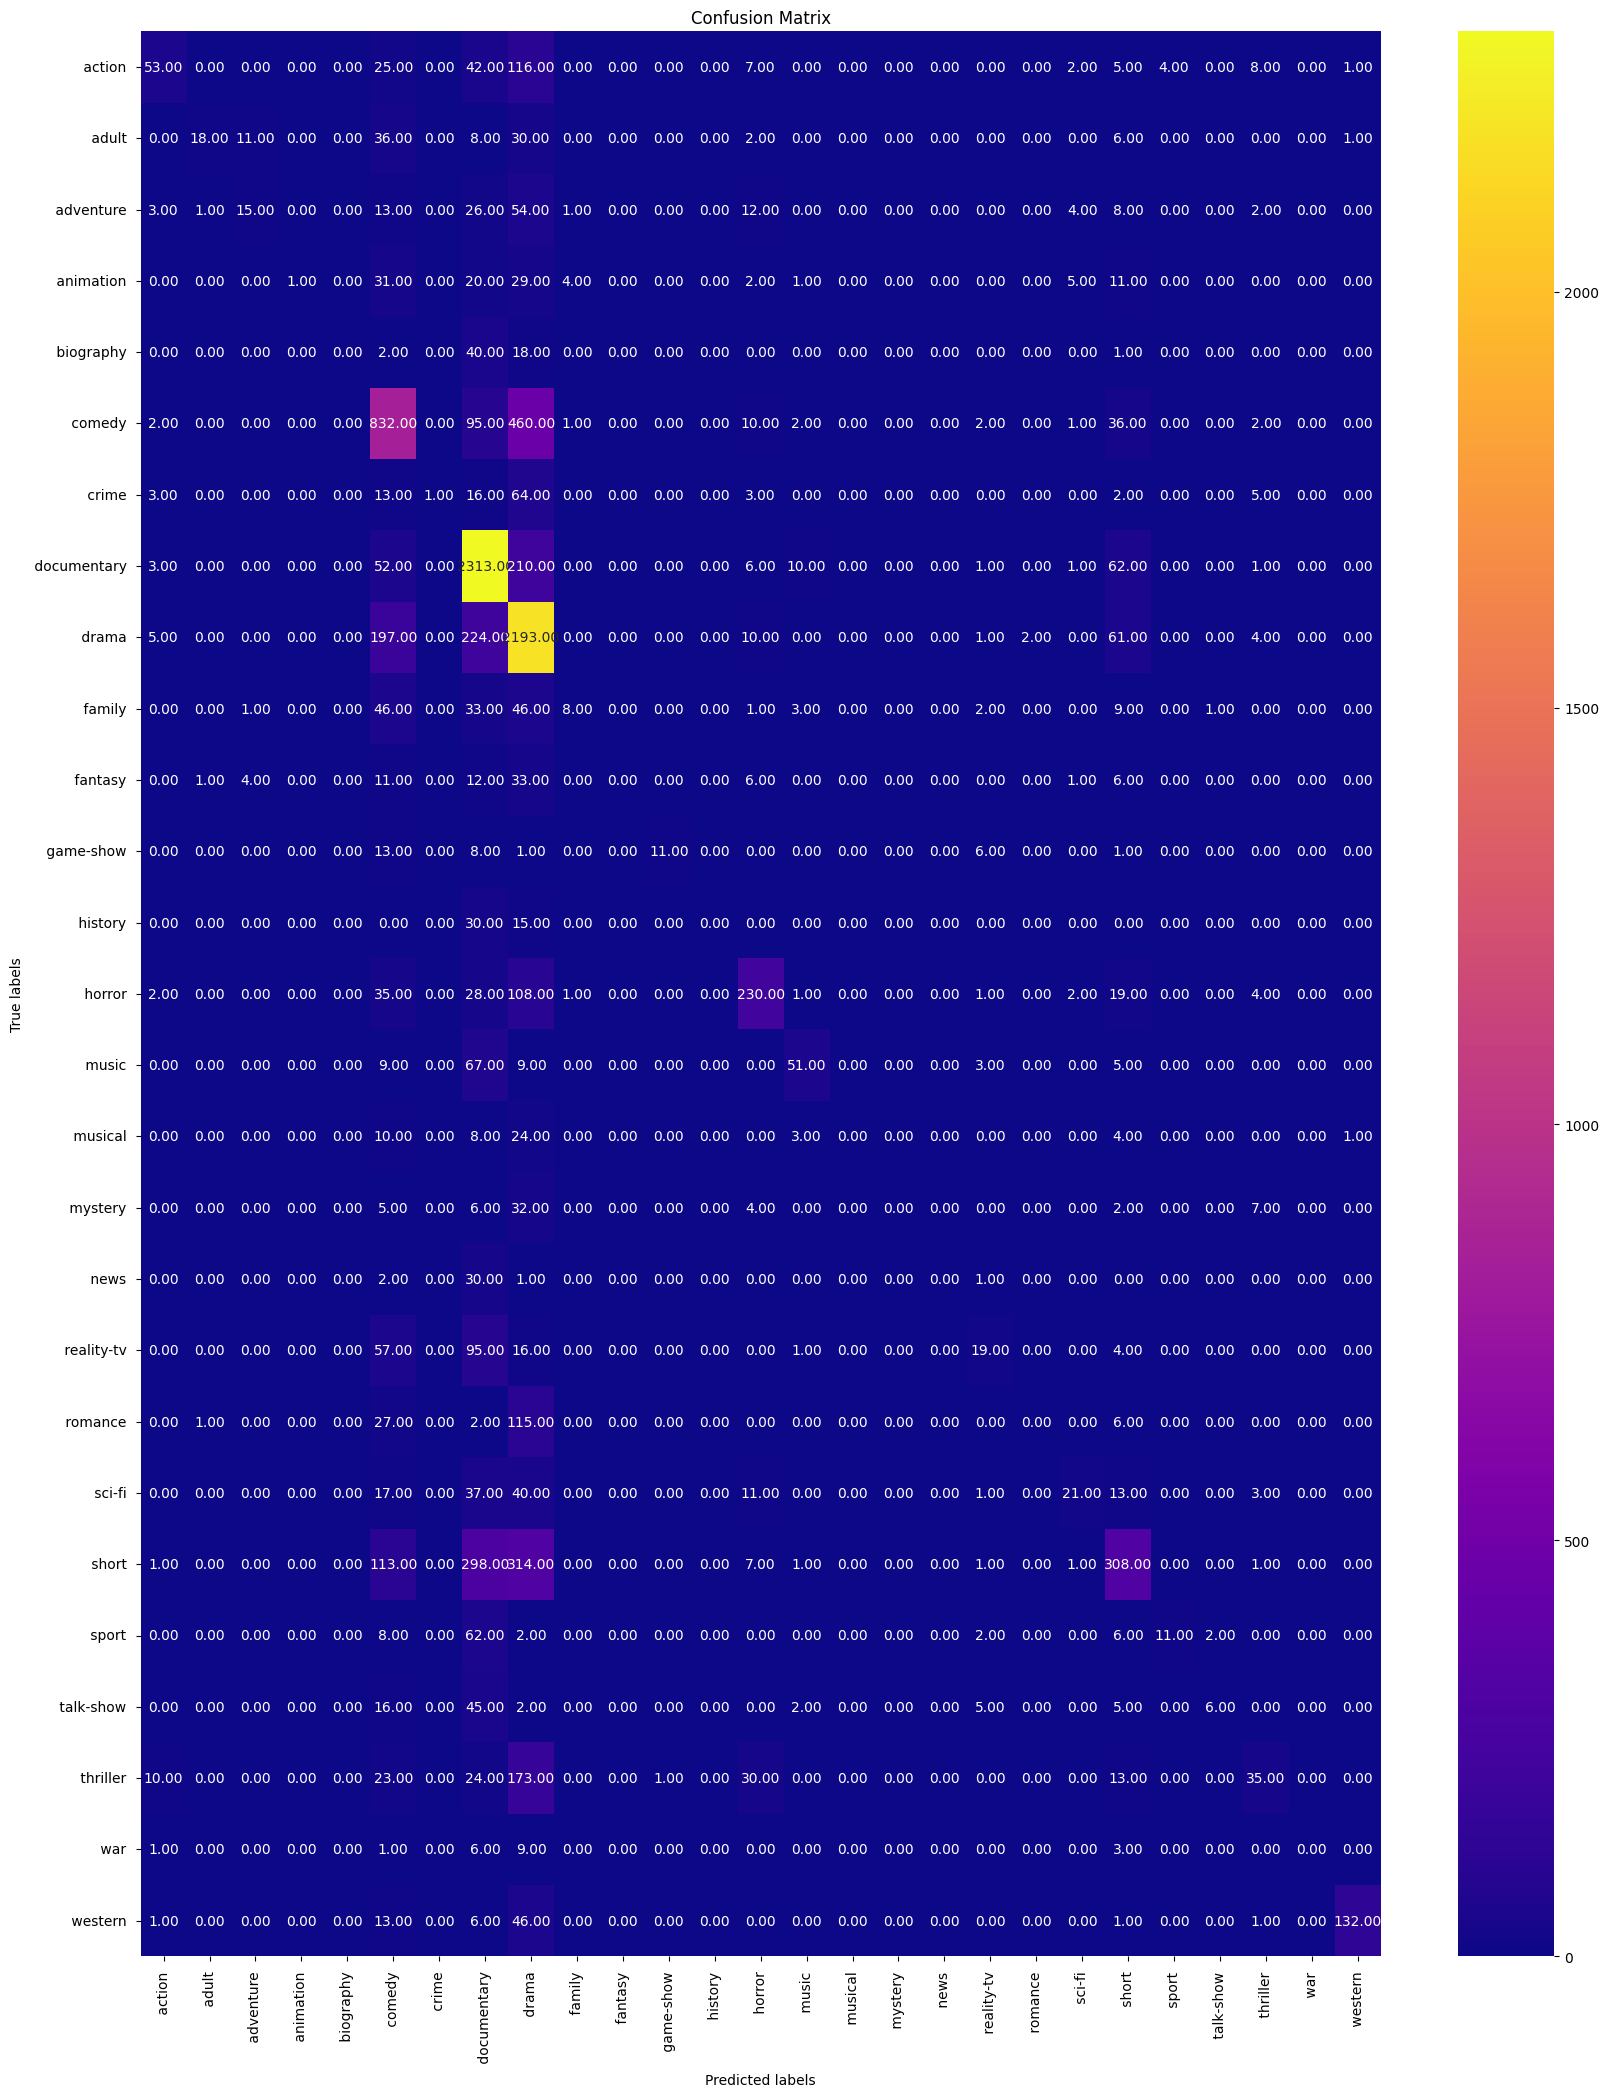

Classification Report:
               precision    recall  f1-score       support
 action         0.630952  0.201521  0.305476    263.000000
 adult          0.857143  0.160714  0.270677    112.000000
 adventure      0.483871  0.107914  0.176471    139.000000
 animation      1.000000  0.009615  0.019048    104.000000
 biography      0.000000  0.000000  0.000000     61.000000
 comedy         0.517735  0.576577  0.545574   1443.000000
 crime          1.000000  0.009346  0.018519    107.000000
 documentary    0.645909  0.869876  0.741346   2659.000000
 drama          0.527163  0.813126  0.639638   2697.000000
 family         0.533333  0.053333  0.096970    150.000000
 fantasy        0.000000  0.000000  0.000000     74.000000
 game-show      0.916667  0.275000  0.423077     40.000000
 history        0.000000  0.000000  0.000000     45.000000
 horror         0.674487  0.533643  0.595855    431.000000
 music          0.680000  0.354167  0.465753    144.000000
 musical        0.000000  0.00000

In [28]:
clf_logreg = LogisticRegression(multi_class='multinomial', solver='sag')
clf_logreg.fit(X_train, y_train)

y_pred = clf_logreg.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cr = classification_report(y_val, y_pred, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(20, 25))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:")
print(cr_df)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)


C:\Users\guvva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


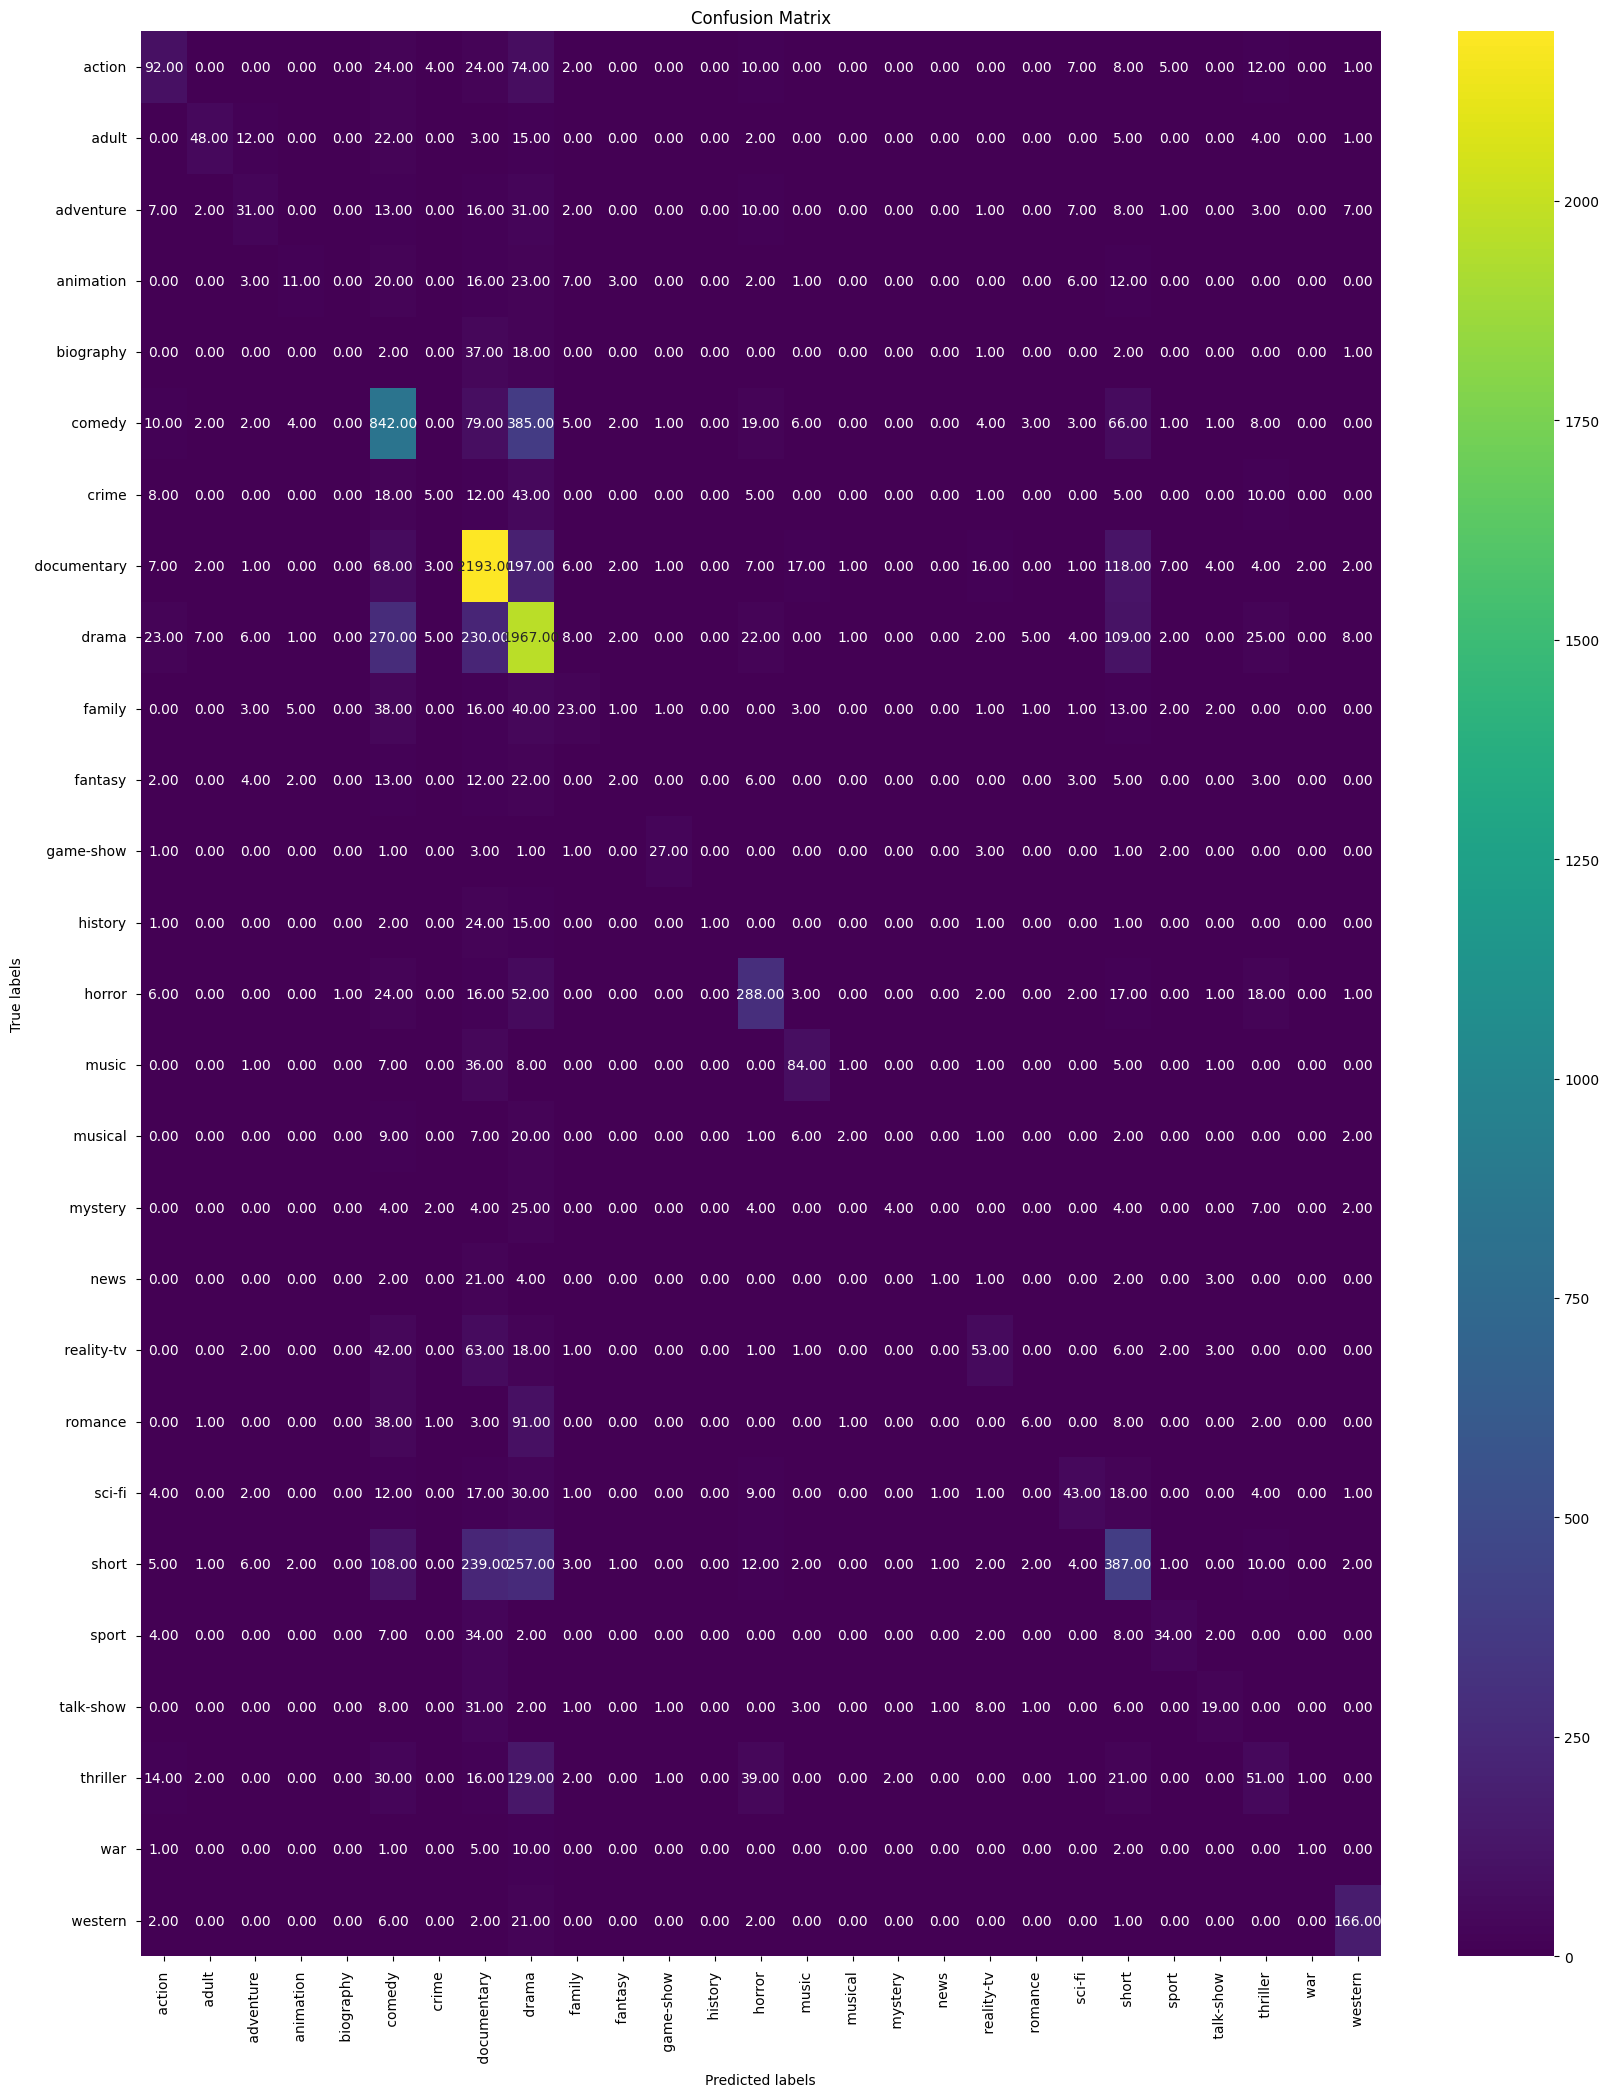

Classification Report:
               precision    recall  f1-score      support
 action         0.491979  0.349810  0.408889    263.00000
 adult          0.738462  0.428571  0.542373    112.00000
 adventure      0.424658  0.223022  0.292453    139.00000
 animation      0.440000  0.105769  0.170543    104.00000
 biography      0.000000  0.000000  0.000000     61.00000
 comedy         0.516248  0.583507  0.547820   1443.00000
 crime          0.250000  0.046729  0.078740    107.00000
 documentary    0.694207  0.824746  0.753867   2659.00000
 drama          0.562000  0.729329  0.634823   2697.00000
 family         0.370968  0.153333  0.216981    150.00000
 fantasy        0.153846  0.027027  0.045977     74.00000
 game-show      0.843750  0.675000  0.750000     40.00000
 history        1.000000  0.022222  0.043478     45.00000
 horror         0.656036  0.668213  0.662069    431.00000
 music          0.666667  0.583333  0.622222    144.00000
 musical        0.333333  0.040000  0.071429     

In [32]:
svc=LinearSVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_val)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cr = classification_report(y_val, y_pred, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(20, 25))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:")
print(cr_df)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)